In [1]:
# import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


# import the definition from the helpers file in the src folder
import os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.helpers import identify_missing_data, one_hot



### Exploring Data

In [2]:
# read the data
users_data = pd.read_pickle("../data/users_data_final.pkl")


In [3]:
users_data.head()

,user_id,number_transactions,total_amount_usd,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,term_deposit,date_joined,device
0,9231c446-cb16-4b2b-a7f7-ddfc8b25aaf6,3.0,2143.0,58,management,married,tertiary,False,True,False,None,261,1,-1,0,None,False,1998-08-23,mobile
1,bb92765a-08de-4963-b432-496524b39157,NaN,NaN,44,technician,single,secondary,False,True,False,None,151,1,-1,0,None,False,2008-07-15,desktop
2,573de577-49ef-42b9-83da-d3cfb817b5c1,2.0,2.0,33,entrepreneur,married,secondary,False,True,True,None,76,1,-1,0,None,False,2002-06-04,mobile
3,d6b66b9d-7c8f-4257-a682-e136f640b7e3,NaN,NaN,47,blue-collar,married,None,False,True,False,None,92,1,-1,0,None,False,1995-06-29,tablet
4,fade0b20-7594-4d9a-84cd-c02f79b1b526,1.0,1.0,33,None,single,None,False,False,False,None,198,1,-1,0,None,False,1995-08-01,mobile


In [4]:
users_data.shape

(45209, 19)

In [5]:
# check the summary 

users_data.info()

# 7 variables with data type object that will need encoding

<class 'pandas.core.frame.DataFrame'>
Index: 45209 entries, 0 to 45215
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              45209 non-null  object        
 1   number_transactions  35210 non-null  float64       
 2   total_amount_usd     35210 non-null  float64       
 3   age                  45209 non-null  int64         
 4   job                  44921 non-null  object        
 5   marital              45209 non-null  object        
 6   education            43352 non-null  object        
 7   default              45209 non-null  bool          
 8   housing              45209 non-null  bool          
 9   loan                 45209 non-null  bool          
 10  contact              32191 non-null  object        
 11  duration             45209 non-null  int64         
 12  campaign             45209 non-null  int64         
 13  pdays                45209 non-null 

In [6]:
identify_missing_data(users_data)

# no missing data, yay - we can continue

,feature,percent_missing,data_type
0,poutcome,81.75,object
1,contact,28.80,object
2,total_amount_usd,22.12,float64
3,number_transactions,22.12,float64
4,education,4.11,object
5,job,0.64,object
6,device,0.21,object
7,date_joined,0.07,datetime64[ns]


### Data Cleaning

In [7]:
# data cleaning

users_data_cleaned = users_data[~users_data.date_joined.isnull()]



In [8]:
print(users_data.shape)
print(users_data_cleaned.shape)

# lost 30 rows of data

(45209, 19)
(45179, 19)


### Feature Engineering

#### Handling Missing Data

In [9]:
# use definition to produce a DataFrame that summarises missing data

missing_df = identify_missing_data(users_data_cleaned)
missing_df

,feature,percent_missing,data_type
0,poutcome,81.75,object
1,contact,28.80,object
2,total_amount_usd,22.11,float64
3,number_transactions,22.11,float64
4,education,4.11,object
5,job,0.64,object
6,device,0.21,object


In [10]:
print("number of features with missing data:", missing_df.shape[0])

number of features with missing data: 7


In [11]:
# where more than 80% missing data drop this feature

feature_to_drop = list(missing_df[missing_df.percent_missing > 80].feature)
users_data_cleaned = users_data_cleaned.drop(feature_to_drop, axis = 1)

In [12]:
# check this was dropped

missing_df = identify_missing_data(users_data_cleaned)
missing_df

,feature,percent_missing,data_type
0,contact,28.80,object
1,total_amount_usd,22.11,float64
2,number_transactions,22.11,float64
3,education,4.11,object
4,job,0.64,object
5,device,0.21,object


In [13]:
# if feature has data type object and missing values, fill with Unknown

users_data_cleaned['contact'].fillna("Unknown", inplace = True)
users_data_cleaned['education'].fillna("Unknown", inplace = True)
users_data_cleaned['job'].fillna("Unknown", inplace = True)
users_data_cleaned['device'].fillna("Unknown", inplace = True)

In [14]:
# check this was handled

missing_df = identify_missing_data(users_data_cleaned)
missing_df

,feature,percent_missing,data_type
0,total_amount_usd,22.11,float64
1,number_transactions,22.11,float64


In [15]:
# if feature has data type float and missing values, fill with 0

users_data_cleaned['number_transactions'].fillna(0, inplace = True)
users_data_cleaned['total_amount_usd'].fillna(0, inplace = True)

In [16]:
# check we have no more missing data

missing_df = identify_missing_data(users_data_cleaned)
missing_df

# we have no missing data yay,

,feature,percent_missing,data_type


#### Feature Selection

In [17]:
# drop date joined as datetime, and needs further processing

users_data_cleaned.drop(["date_joined"], axis = 1, inplace = True)

#### One hot encoding variables

In [18]:
#  but do we have any non numrical data types left?

users_data_cleaned.info()

# we have five objects, so we need to encode them

<class 'pandas.core.frame.DataFrame'>
Index: 45179 entries, 0 to 45215
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              45179 non-null  object 
 1   number_transactions  45179 non-null  float64
 2   total_amount_usd     45179 non-null  float64
 3   age                  45179 non-null  int64  
 4   job                  45179 non-null  object 
 5   marital              45179 non-null  object 
 6   education            45179 non-null  object 
 7   default              45179 non-null  bool   
 8   housing              45179 non-null  bool   
 9   loan                 45179 non-null  bool   
 10  contact              45179 non-null  object 
 11  duration             45179 non-null  int64  
 12  campaign             45179 non-null  int64  
 13  pdays                45179 non-null  int64  
 14  previous             45179 non-null  int64  
 15  term_deposit         45179 non-null  bool

In [19]:
# before encoding check the number of categories of 
# you want to avoid encoding features with too many categories. 

categories = (users_data_cleaned.select_dtypes("object")
            .apply(pd.Series.nunique)
            .sort_values(ascending=False))
        
categories

# credit for this code goes to one of my previous students, Terje


user_id      45179
job             12
education        4
device           4
marital          3
contact          3
dtype: int64

In [20]:
# drop user_id as has more than 15 categories

users_data_cleaned.drop(["user_id"], axis = 1, inplace = True)

In [21]:
# encode all of the categorical columns

categorical_columns = list(users_data_cleaned.select_dtypes(['object']).columns)

users_data_cleaned_w_encoding = one_hot(users_data_cleaned, categorical_columns)

In [22]:
# check shape of new data - we have ten new columns
print(users_data_cleaned.shape)
print(users_data_cleaned_w_encoding.shape)

(45179, 16)
(45179, 37)


In [23]:
users_data_cleaned_w_encoding.head()

,number_transactions,total_amount_usd,age,default,housing,loan,duration,campaign,pdays,previous,...,education_primary,education_secondary,education_tertiary,contact_Unknown,contact_cellular,contact_telephone,device_Unknown,device_desktop,device_mobile,device_tablet
0,3.0,2143.0,58,False,True,False,261,1,-1,0,...,False,False,True,True,False,False,False,False,True,False
1,0.0,0.0,44,False,True,False,151,1,-1,0,...,False,True,False,True,False,False,False,True,False,False
2,2.0,2.0,33,False,True,True,76,1,-1,0,...,False,True,False,True,False,False,False,False,True,False
3,0.0,0.0,47,False,True,False,92,1,-1,0,...,False,False,False,True,False,False,False,False,False,True
4,1.0,1.0,33,False,False,False,198,1,-1,0,...,False,False,False,True,False,False,False,False,True,False


In [24]:
# one last check - do we have any missing data or non numerical data?

users_data_cleaned_w_encoding.info()

# let's continue....

<class 'pandas.core.frame.DataFrame'>
Index: 45179 entries, 0 to 45215
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   number_transactions  45179 non-null  float64
 1   total_amount_usd     45179 non-null  float64
 2   age                  45179 non-null  int64  
 3   default              45179 non-null  bool   
 4   housing              45179 non-null  bool   
 5   loan                 45179 non-null  bool   
 6   duration             45179 non-null  int64  
 7   campaign             45179 non-null  int64  
 8   pdays                45179 non-null  int64  
 9   previous             45179 non-null  int64  
 10  term_deposit         45179 non-null  bool   
 11  job_Unknown          45179 non-null  bool   
 12  job_admin.           45179 non-null  bool   
 13  job_blue-collar      45179 non-null  bool   
 14  job_entrepreneur     45179 non-null  bool   
 15  job_housemaid        45179 non-null  bool

### Machine Learning Model

In [25]:
# we need to define our features and target

target = users_data_cleaned_w_encoding.total_amount_usd
features = users_data_cleaned_w_encoding.drop(['total_amount_usd'], axis = 1)

In [26]:
# since our target is a continuous variables we use a regression algorithm

users_data_cleaned_w_encoding.total_amount_usd

0        2143.0
1           0.0
2           2.0
3           0.0
4           1.0
          ...  
45211     825.0
45212    1729.0
45213    5715.0
45214       0.0
45215    2971.0
Name: total_amount_usd, Length: 45179, dtype: float64

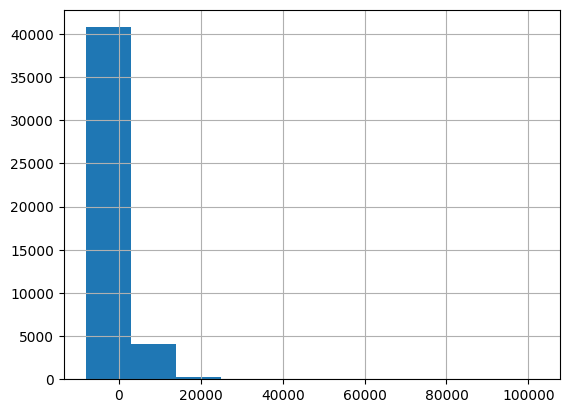

In [27]:
# visualise the target

target.hist();


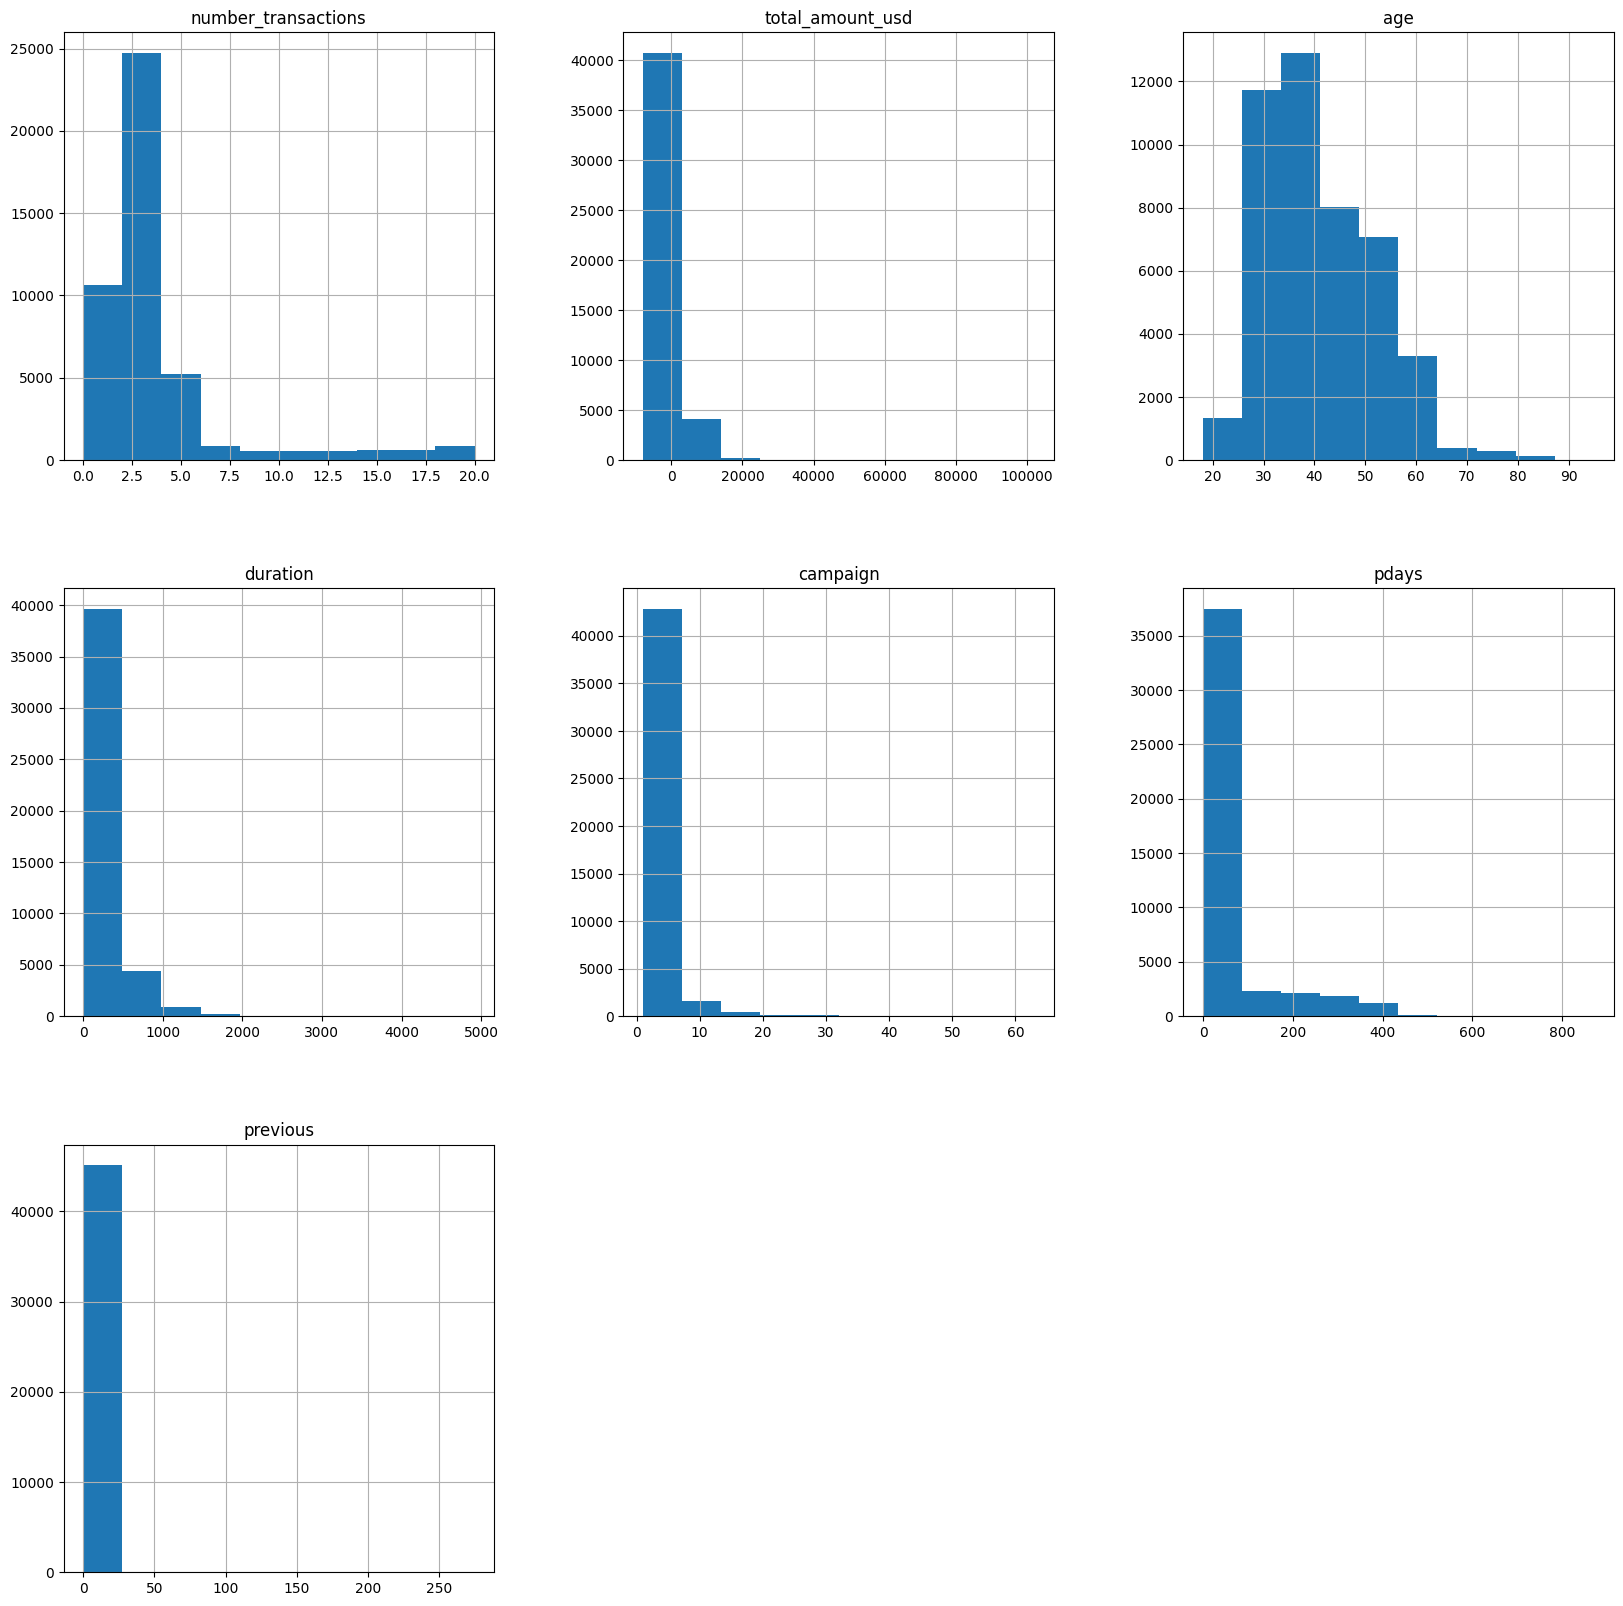

In [28]:
# scale the data
# but look at the distribution of the underlying data

users_data_cleaned_w_encoding.hist(figsize = (20, 20));

# since our data is not normally distributed, we are going to use normalisation for scaling

In [29]:
# code to scale the data using the normalisation technique

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(features)
features_scaled = min_max_scaler.transform(features)


In [30]:
# split our data into train and test


X_train, X_test, y_train, y_test = train_test_split(features_scaled,
                                                    target,
                                                    test_size = 0.2,
                                                    random_state = 0)

In [31]:
# print the shape of the training data

print("Training Data")
print(X_train.shape)
print(y_train.shape)

Training Data
(36143, 36)
(36143,)


In [32]:
# print the shape of the test data

print("Test Data")
print(X_test.shape)
print(y_test.shape)

Test Data
(9036, 36)
(9036,)


In [33]:
# Import the Linear Regression model from sklearn


lr = LinearRegression()

In [34]:
# training the model

lr.fit(X_train, y_train)

LinearRegression()

In [35]:
# make predictions on unseen data

y_pred = lr.predict(X_test)
y_pred

array([ 827.5  , 1090.5  , 1153.625, ...,  536.625, 1463.875,  705.   ])

In [36]:
print("first five predicted total amounts:", y_pred[0:5])
print("first five actual total amounts:", list(y_test[0:5]))

first five predicted total amounts: [ 827.5   1090.5   1153.625 1372.375 1061.125]
first five actual total amounts: [1196.0, 566.0, 0.0, 4833.0, 3.0]


In [37]:
# evaluate how the model is performing


r2_score(y_test, y_pred)

# Pretty close to 0, which means the features do not explain the target

0.024069029364758965

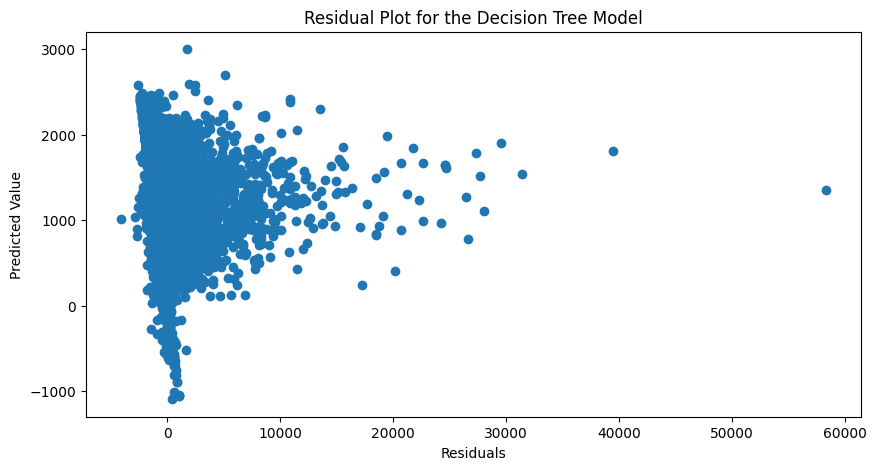

In [38]:
# residual plot - shows where all the error lies

plt.rcParams["figure.figsize"] = (10,5)

residuals = y_test - y_pred

plt.scatter(residuals, y_pred)
plt.title("Residual Plot for the Decision Tree Model")
plt.xlabel("Residuals")
plt.ylabel("Predicted Value")
plt.show();

# we want them the points to be centred around 0